In [432]:
import cv2
import matplotlib.pyplot as plt
from cv2.typing import *
import numpy as np
import matplotlib.patches as patches


def load_image(image_path: str):
    image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
    #return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)


def display_image(image: MatLike, title: str):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off the axis

def split_alpha(image):
    #rgb_image = cv2.cvtColor(image,cv2.COLOR_RGBA2RGB)
    rgb_image = image[:,:,:3]
    alpha = image[:,:,3]
    return rgb_image,alpha

def merge_alpha(image,alpha):
    rgba_image = cv2.cvtColor(image,cv2.COLOR_RGB2RGBA)
    #rgba_image = np.resize(image,([*image.shape[:2],4]))
    #rgba_image[:,:,3]=alpha
    rgba_image = np.dstack((image,alpha))
    return rgba_image

def quantize_image(image: MatLike, n_colors):
    Z = image.reshape((-1, 3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    final_image = res.reshape((image.shape))
    
    return final_image

In [139]:
colors = 13*12
quantized_image = quantize_image(
    load_image(image_path="images/Ittens Colors.png"), colors)

In [135]:
def get_colors(image_array):
    colors = {}
    i = 0
    j = 0
    while i < image_array.shape[0]:
        while j < image_array.shape[1]:
            pixel = tuple(image_array[i, j])
            if pixel in colors:
                colors[pixel] = colors[pixel]+1
            else:
                colors[pixel] = 1
            j = j+1
        j = 0
        i = i+1
    return colors

In [24]:
def build_ittens_colors(image: MatLike):
    ittens_colors = {}
    i = 1
    j = 1
    cut = (int(image.shape[1]/12),  int(image.shape[0]/12))
    start_point = [0, cut[0]]
    while i < 13:
        ittens_colors[i] = []
        while j < 13:
            y = start_point[0]
            x = start_point[1]
            cropped_image = image[y:y+cut[0], x:x+cut[1]]
            colors = get_colors(quantize_image(cropped_image, 1)).keys()
            first_color = next(iter(colors), None)
            if first_color is not None:
                ittens_colors[i].append(first_color)
            start_point[0] = start_point[0] + cut[0]
            j += 1
        j = 1
        start_point[0] = 0
        start_point[1] = start_point[1] + cut[1]
        i += 1
    return ittens_colors

In [369]:
ittens_image = load_image("images/Ittens Colors.png")
ittens_colors = build_ittens_colors(ittens_image[:,:,:3])
print(len(ittens_colors))

12


In [26]:
def get_color_value(ittens_colors: dict):
    for color in ittens_colors.keys():
        colors = ittens_colors.get(color)
        fig, ax = plt.subplots(1, 1, figsize=(10, 2))

        # Para cada color en la lista de colores
        for i, color in enumerate(colors):
            # Convertir el color de formato string a formato RGB
            rgb = color
            rgb = [c/255. for c in rgb]  # Normalizar a [0, 1]

            # Dibujar un rectángulo en el eje con el color correspondiente
            rect = patches.Rectangle((i, 0), 1, 1, facecolor=rgb)
            ax.add_patch(rect)

        # Configurar el eje
        ax.set_xlim(0, len(colors))
        ax.set_ylim(0, 1)
        ax.axis('off')  # Ocultar los ejes

        plt.show()

In [27]:
def show_color_palette(colors):
    c = np.array(colors)/255
    fig,ax = plt.subplots()
    for i,color in enumerate(c):
        rect = patches.Rectangle((i,0),1,0.2,facecolor=color)
        ax.add_patch(rect)
    ax.set_xlim(0,len(colors))
    ax.set_ylim(0,0.2)
    ax.axis("off")

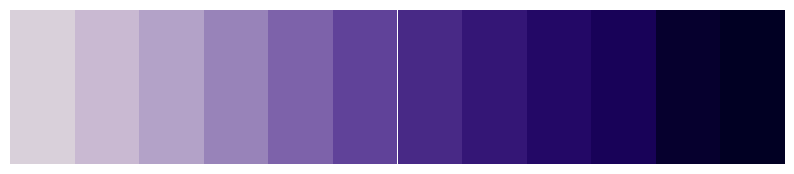

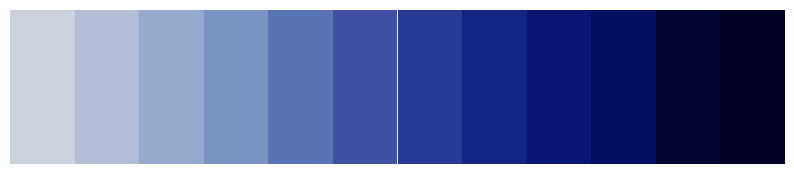

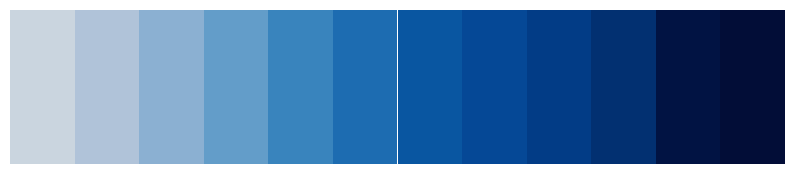

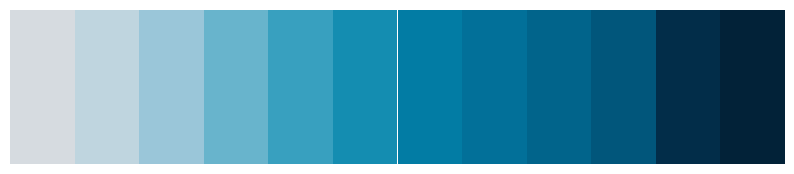

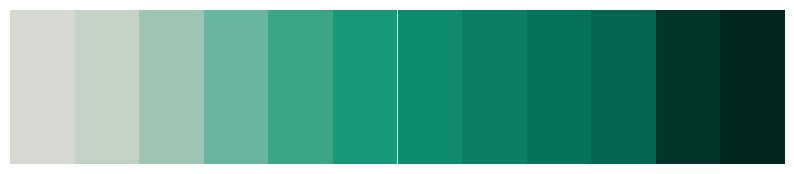

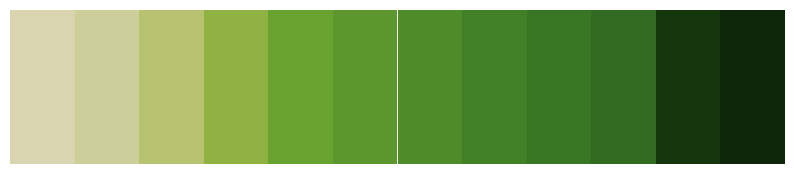

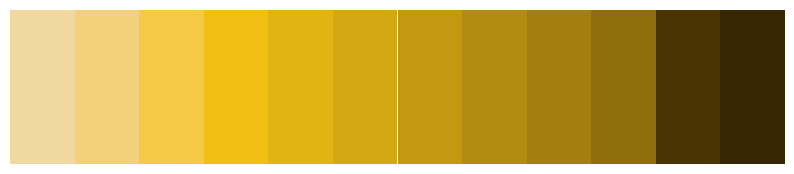

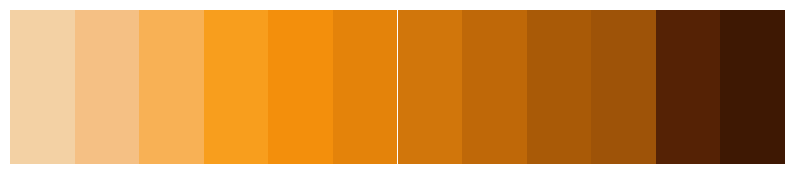

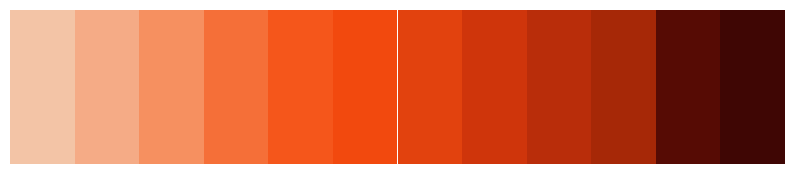

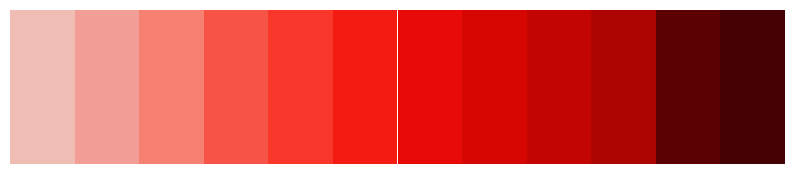

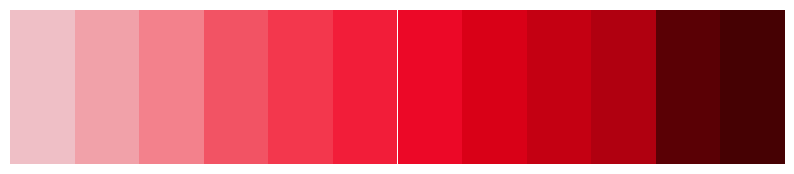

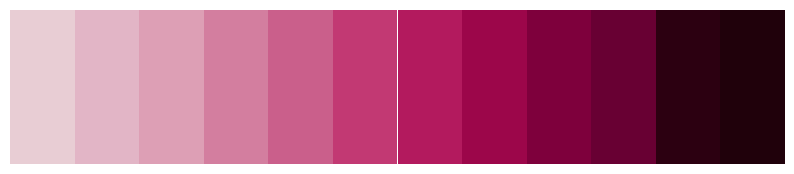

In [28]:
get_color_value(ittens_colors)

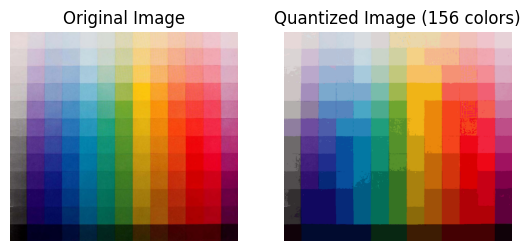

In [29]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
display_image(load_image(image_path="images/Ittens Colors.png"),
              'Original Image')


plt.subplot(132)
display_image(quantized_image, f'Quantized Image ({colors} colors)')

In [457]:
def color_distance(c1,c2):
    c1_i = np.array(c1).astype(int)
    c2_i = np.array(c2).astype(int)
    d = np.subtract(c1_i,c2_i)
    d = np.linalg.norm(d,axis=2)
    return d
def list_distance(n,pos1,pos2):
    distance = abs(pos1-pos2)
    return min(distance,n-distance)
def matrix_min_indexes(matrix):
    min_index = np.argmin(matrix)
    (i1,i2) = np.unravel_index(min_index,matrix.shape)
    return (i1+1,i2)
def angle_to_index(angle,list_length):
    return round(angle/360*list_length)
def rgb_to_hsv(rgb):
    to_convert = np.array([[rgb]],dtype=np.uint8)
    return cv2.cvtColor(to_convert,cv2.COLOR_RGB2HSV)[0][0]
def rgbs_to_hsv(rgbs):
    to_convert = np.array([rgbs],dtype=np.uint8)
    return cv2.cvtColor(to_convert,cv2.COLOR_RGB2HSV)[0]
def group_hues(colors, n):
    """
    Given some colors and N hues to separate into, returns a dictionary that maps each color
    to its group index
    --- 
    Inputs
        colors: A list of tuples, each containing a color in RGB values.
        n: The number of hue groups to separate into
    Returns
        index_groups: A list of the hue groups, with the colors represented as indexes of the original list
        color_groups: A list of the hue groups, with the colors represented with their RGB value
        group_hues: A list that contains the hues of each group
    """
    
    hues = [rgb_to_hsv(c)[0] for c in colors]
    hues = np.float32(hues)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,labels,centers = cv2.kmeans(hues, n, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    group_hues = centers
    labels = labels.flatten()
    
    groups = [hues[labels==i] for i in range(n)]
    index_groups = [np.arange(len(colors))[labels == i].tolist() for i in range(n)]
    color_groups = [np.array(colors)[labels==i].tolist() for i in range(n)]
    color_groups = [[tuple(c) for c in g] for g in color_groups]

    hue_mappings = {h:i for i,g in enumerate(groups) for h in g}
    color_mappings = {tuple(colors[i]):hue_mappings[hues[i]] for i in range(len(colors))}
    return index_groups, color_groups, group_hues
def group_hues_threshold(colors,hue_threshold,color_scheme):
    groups = []
    avg_hues = []
    groups_quantities = []
    palette = list(colors.keys())
    quantities = [colors[c] for c in palette]
    
    hues = find_closest_color(palette,color_scheme)
    hues = [t[0] for t in hues]
    
    available = list(range(len(palette)))
    while available:
        most_frequent = max(available,key=lambda i:colors[palette[i]])
        
        distances = [list_distance(len(color_scheme),hues[i],hues[most_frequent]) for i in available]
        
        group = list(filter(lambda i: distances[i]<=hue_threshold,range(len(available))))
        group = [available[i] for i in group]
        groups.append(group)
        
        group_quantity = sum([colors[palette[i]] for i in group])
        groups_quantities.append(group_quantity)

        avg_hue = round(sum([hues[i] for i in group])/len(group))
        avg_hues.append(avg_hue)
        
        available = list(filter(lambda i: i not in group,available))
    return groups, avg_hues, groups_quantities
def find_closest_color(color,color_scheme:dict):
    """
    Given a color and a scheme, returns the index corresponding to the closest match in the color scheme
    ---
    Inputs
        color: The tuple of the RGB color to find the match for
        color_scheme: Dictionary with RGB values grouped by hues
    Returns
        index: A tuple with the 2 values needed to index the scheme for the matching color
    """
    matrix = [color_scheme[key] for key in sorted(color_scheme)]
    matrix = np.array(matrix)
    matrix = np.uint64(matrix)
    min_indices = [matrix_min_indexes(color_distance(c,matrix)) for c in color]
    return min_indices
def convert_im_to_scheme(quantized_image,color_scheme):
    colors = get_colors(quantized_image)
    color_palette = list(colors.keys())
    indexes = find_closest_color(color_palette,ittens_colors)
    new_im = quantized_image.copy()

    for i,og in enumerate(color_palette):
        mask = cv2.inRange(quantized_image,np.array(og),np.array(og))
        ind = indexes[i]
        new_im[mask > 0] = color_scheme[ind[0]][ind[1]]
    return new_im
def convert_im_palette(quantized_image,color_palette):
    colors = get_colors(quantized_image)
    og_palette = list(colors.keys())
    new_im = quantized_image.copy()
    for i,og in enumerate(og_palette):
        mask = cv2.inRange(quantized_image,np.array(og),np.array(og))
        new_im[mask > 0] = color_palette[i]
    return new_im

# Aplicación a un diseño de personaje

## Diseño original

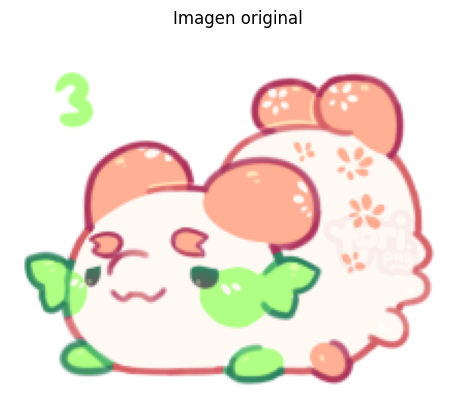

In [475]:
rgba = load_image("images/Slug.png")
image,alpha = split_alpha(rgba)
q_im = quantize_image(image,6)
display_image(rgba,"Imagen original")

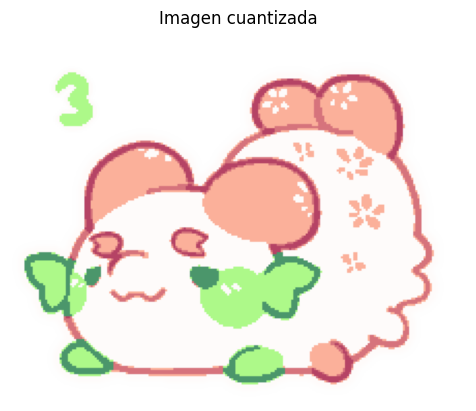

In [476]:
display_image(merge_alpha(q_im,alpha),"Imagen cuantizada")

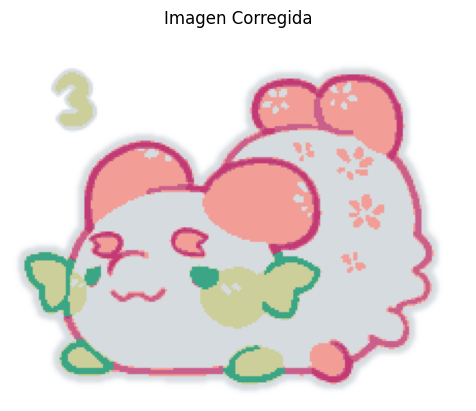

In [477]:
colors = get_colors(q_im)
color_palette = list(colors.keys())
indexes = find_closest_color(color_palette,ittens_colors)
new_colors = [ittens_colors[i][j] for i,j in indexes]

corrected = convert_im_palette(q_im,new_colors)
rgba_corrected = merge_alpha(corrected,alpha)
display_image(rgba_corrected,"Imagen Corregida")

## Retoque de paleta de colores

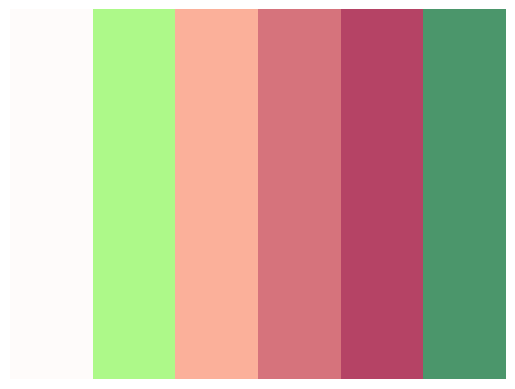

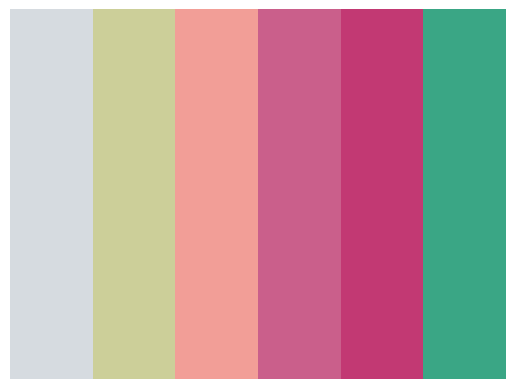

In [478]:
show_color_palette(color_palette)
show_color_palette(new_colors)

In [479]:
def complementary_palette(q_im, hue_tolerance, color_scheme):
    colors = get_colors(q_im)
    palette = list(colors.keys())
    # Could find a way to remove this extra call to find_closest_color,
    # given that group_hues_threshold also calls it
    correct_palette = find_closest_color(palette, color_scheme)

    hue_groups, avg_hues, hue_quantities = group_hues_threshold(colors, hue_tolerance, color_scheme)

    max_hue_i = max(range(len(hue_groups)), key=lambda i: hue_quantities[i])
    max_hue = avg_hues[max_hue_i]

    complementary_hue = angle_to_index(180, len(color_scheme)) + max_hue
    complementary_hue = complementary_hue % len(color_scheme)

    to_modify_i = list(filter(
        lambda i: i not in hue_groups[max_hue_i],
        range(len(palette))
    ))
    #print(f"Initial hue:{max_hue}\nComplementary Hue:{complementary_hue}\nDo not modify:{hue_groups[max_hue_i]}\nModify:{to_modify_i}")

    new_palette = np.array(correct_palette[:])
    new_palette[to_modify_i, 0] = complementary_hue
    new_palette = [color_scheme[i][j] for i, j in new_palette]
    return convert_im_palette(q_im, new_palette)

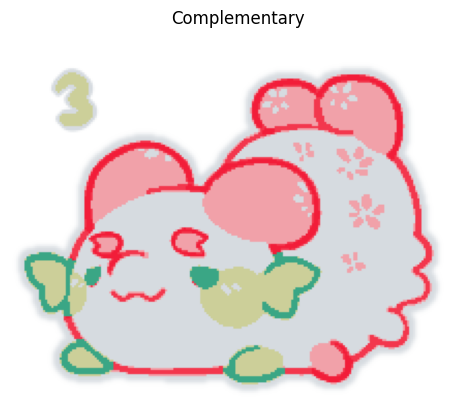

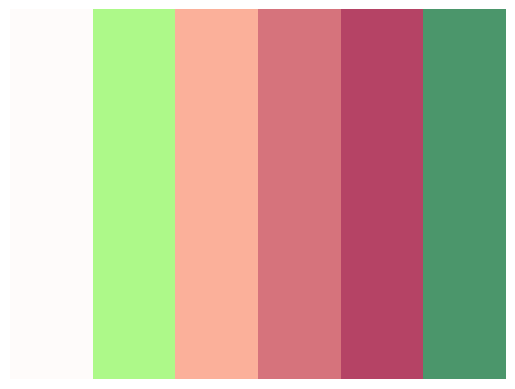

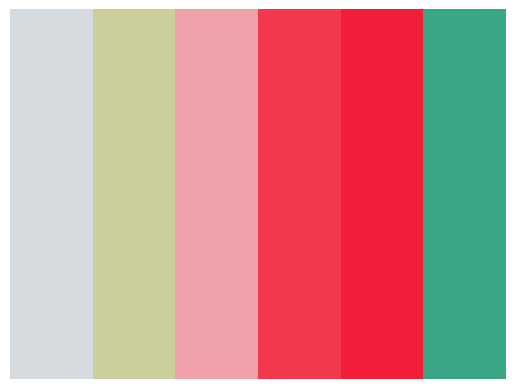

In [481]:
comp_im = complementary_palette(q_im,2,ittens_colors)
display_image(merge_alpha(comp_im,alpha),"Complementary")

show_color_palette(color_palette)
show_color_palette(list(get_colors(comp_im).keys()))

In [297]:
matrix = [ittens_colors[key] for key in (ittens_colors)]
matrix = np.array(matrix)